In [1]:
import logging
import os
import pandas as pd
import re
import time

%load_ext autoreload
%autoreload 2

from pathlib import Path

# Disable logging of the program in the notebook
os.environ["LOGLEVEL"] = "INFO"

logging.basicConfig()
logging.root.setLevel(logging.INFO)
logging.basicConfig(level=logging.INFO)

logger = logging.getLogger('__main__')
logger.setLevel(os.environ.get("LOGLEVEL", logging.INFO))

pybooklogger = logging.getLogger('pybook')
pybooklogger.setLevel(logging.INFO)

import sys
sys.path.append(os.path.abspath(os.path.join(os.path.dirname(os.path.abspath("__file__")), '..')))
from setup import *
from tad_help import TadRunner

In [10]:
save_dir = os.path.join(os.path.dirname(os.path.abspath("__file__")), "results", "corridor")
layout = Layout("../data/corridor/corridor_tracks.json")
scenario_file = "../data/corridor/scenario_2trains.json"

tad_exp = TadRunner(layout, scenario_file, save_dir, use_acceleration=False)
experiments = tad_exp.run("1", "o", "U|1", "V|1", timeout=600, offset=0, max_buffer_time=3)

experiments[0].metadata = {'color': 'Red',   'label': '@SIPP',    'offset': 0, 'linestyle': 3}
experiments[1].metadata = {'color': 'Blue',  'label': 'FlexSIPP', 'offset': 0, 'linestyle': 3}
experiments[2].metadata = {'color': 'Green', 'label': 'rSIPP',    'offset': 0, 'linestyle': 3}

os.makedirs(save_dir, exist_ok=True)
path_data = get_path_data(experiments, tad_exp.agent_df, scenario=scenario_file)
path_df = pd.DataFrame(path_data)
path_df.to_csv(save_dir + "/corridor.csv")

time_data = [exp.get_running_time() | exp.get_label() | {'scenario': scenario_file} for exp in experiments]
time_df = pd.DataFrame(time_data)
time_df.to_csv(save_dir + "/corridor-time.csv")

comp_data = [exp.get_complexity()   | exp.get_label() | {'scenario': scenario_file} for exp in experiments]
comp_df = pd.DataFrame(comp_data)
comp_df.to_csv(save_dir + "/corridor-comp.csv")

INFO:__main__.generation.graph:Creating initial signals
INFO:__main__.generation.graph:  0%|          | 0/24 [00:00<?, ?it/s]
INFO:__main__.generation.graph:Found 1 routes [([Node suA, Node wA], 100, 100.0)] for signal block from signal Signal u|A on track uA
INFO:__main__.generation.graph:Found 1 routes [([Node uA], 100, 100.0)] for signal block from signal Signal u|B on track uB
INFO:__main__.generation.graph:Found 1 routes [([Node s1A], 100, 100.0)] for signal block from signal Signal w|A on track wA
INFO:__main__.generation.graph:Found 1 routes [([Node suHatA, Node wA], 100, 100.0)] for signal block from signal Signal uHat|A on track uHatA
INFO:__main__.generation.graph:Found 1 routes [([Node uHatA], 100, 100.0)] for signal block from signal Signal uHat|B on track uHatB
INFO:__main__.generation.graph:Found 1 routes [([Node s2A], 100, 100.0)] for signal block from signal Signal s1|A on track s1A
INFO:__main__.generation.graph:Found 2 routes [([Node wBR, Node suB], 100, 100.0), ([Nod

Graph with 26 edges and 24 nodes:
dict_values([Node r-u|A, Node r-u|B, Node r-w|A, Node r-uHat|A, Node r-uHat|B, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-v|A, Node r-vHat|B, Node r-vHat|A, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B
Graph with 26 edges and 24 nodes:
dict_values([Node r-u|A, Node r-u|B, Node r-w|A, Node r-uHat|A, Node r-uHat|B, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-v|A, Node r-vHat|B, Node r-vHat|A, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B


INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-s2|B
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 14.0, 0, 2, 3, 0) with index 14
INFO:__main__.generation.convert_to_safe_intervals:    Interval (16.01, 36, 2, 0, 0, 0) with index 15
INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-s3|A
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 13.0, 0, 2, 3, 0) with index 16
INFO:__main__.generation.convert_to_safe_intervals:    Interval (14.0, 36, 2, 0, 0, 0) with index 17
INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-s3|B
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 13.0, 0, 2, 3, 0) with index 18
INFO:__main__.generation.convert_to_safe_intervals:    Interval (15.01, 36, 2, 0, 0, 0) with index 19
INFO:__main__.generation.convert_to_safe_intervals:Safe intervals on node r-s4|A
INFO:__main__.generation.convert_to_safe_intervals:    Interval (0, 12.

Graph with 26 edges and 24 nodes:
dict_values([Node r-u|A, Node r-u|B, Node r-w|A, Node r-uHat|A, Node r-uHat|B, Node r-s1|A, Node r-s1|B, Node r-s2|A, Node r-s2|B, Node r-s3|A, Node r-s3|B, Node r-s4|A, Node r-s4|B, Node r-s5|A, Node r-s5|B, Node r-s6|B, Node r-v|B, Node r-v|A, Node r-vHat|B, Node r-vHat|A, Node r-su|B, Node r-suHat|B, Node r-sv|A, Node r-svHat|A]) r-v|B


INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-vHat|A state 34 (0, 36, 0, 0, 0, 0) to r-vHat|B state 32 (0, 10, 0, 2, 0, 0) with zeta 0, alpha 0, beta 9.0, delta 1.0, train_before 0 and train_after 0.
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-vHat|A state 34 (0, 36, 0, 0, 0, 0) to r-vHat|B state 33 (10, 36, 2, 0, 0, 0) with zeta 0, alpha 9.0, beta 10, delta 1.0, train_before 0 and train_after 0.
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-vHat|A state 34 (0, 36, 0, 0, 0, 0) to r-vHat|B state 33 (10, 36, 2, 0, 0, 0) with zeta 0, alpha 10, beta 35.0, delta 1.0, train_before 2 and train_after 0.
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-su|B state 35 (0, 36, 0, 0, 0, 0) to r-u|B state 1 (0, 36, 0, 0, 0, 0) with zeta 0, alpha 0, beta 35.0, delta 1.0, train_before 0 and train_after 0.
INFO:__main__.generation.convert_to_safe_intervals:Edge has interval from r-suHa

Exp @SIPP - atf: <-inf,2.0,4.0,9>
Exp @SIPP - atf: <-inf,17.0,27.0,9>
Exp FlexSIPP - atf: <-inf,2.0,4.0,9>
Exp FlexSIPP: Agent_i 2 is delayed and agent ['0.0001', '1', '0', 'r-s5|A', '0'] is other agent which has atf: <-inf,4.0,5.0,9>
Exp FlexSIPP: Agent_i 2 is delayed and agent ['1.0001', '2', '0', 'r-s4|A', '0'] is other agent which has atf: <-inf,5.0,6.0,9>
Exp FlexSIPP: Agent_i 2 is delayed and agent ['2.0001', '3', '0', 'r-s5|A', '2'] is other agent which has atf: <-inf,6.0,7.0,9>
Exp FlexSIPP - atf: <-inf,17.0,27.0,9>
Exp rSIPP - atf: <-inf,2.0,4.0,9>
Exp rSIPP - atf: <-inf,17.0,27.0,9>


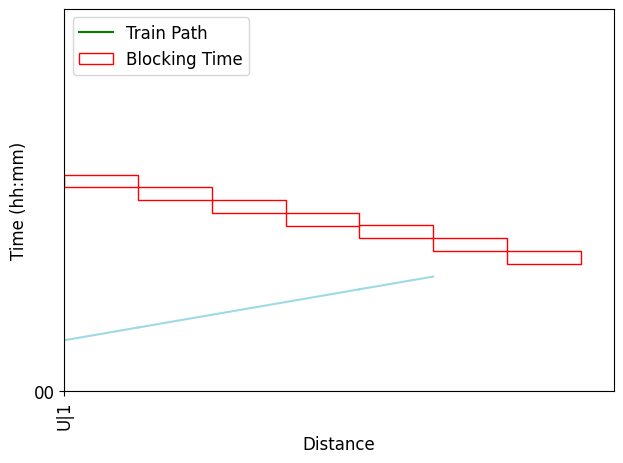

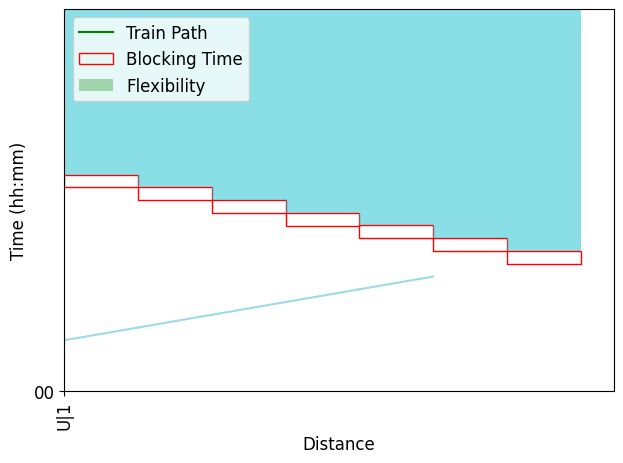

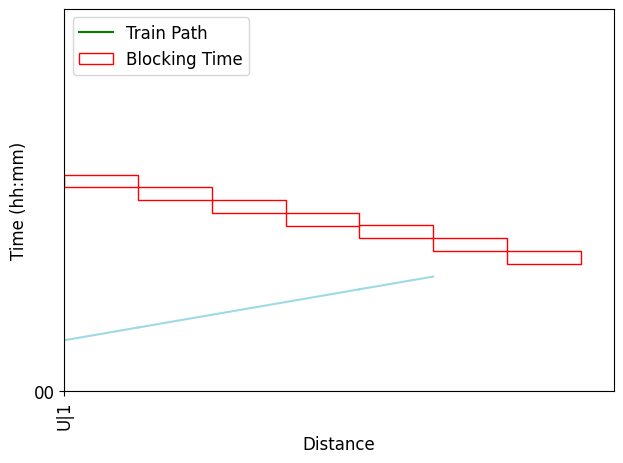

In [9]:
for exp in experiments:
    exp.s.plot(exp.agent.id, exp.block_intervals, exp.buffer_times, exp.recovery_times, True, start="U", end="V", min_y=0, max_y=(30), savefig=f"{save_dir}/blocking_staircase_{exp.metadata['label'].replace(' ', '_')}.png")